# Flipkart Review Sentiment Analysis

## Loading the Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import make_scorer, f1_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import string
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [2]:
df = pd.read_csv("data.csv")

In [3]:
df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [4]:
df.columns

Index(['Reviewer Name', 'Review Title', 'Place of Review', 'Up Votes',
       'Down Votes', 'Month', 'Review text', 'Ratings'],
      dtype='object')

## Exploratory Data Analysis

In [5]:
df.shape

(8518, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


In [7]:
df.isna().sum()

Reviewer Name       10
Review Title        10
Place of Review     50
Up Votes            10
Down Votes          10
Month              465
Review text          8
Ratings              0
dtype: int64

In [8]:
df = df.dropna(subset=['Review text'])

In [9]:
df['Ratings'].value_counts()

Ratings
5    5079
4    1744
1     766
3     615
2     306
Name: count, dtype: int64

<Axes: xlabel='Ratings', ylabel='count'>

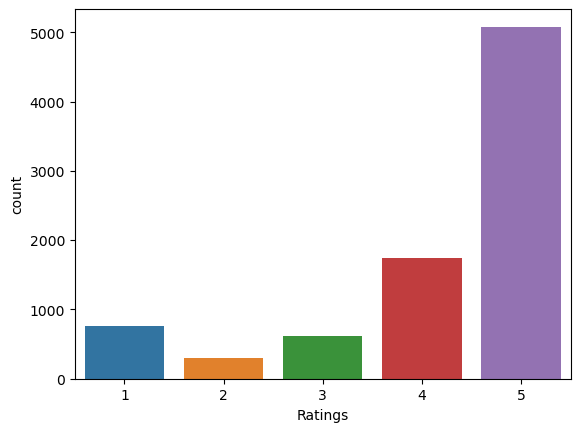

In [10]:
sns.countplot(x='Ratings', data=df)

In [11]:
df['Ratings'] = df['Ratings'].replace({3: 'Positive', 4: 'Positive', 5: 'Positive', 1: 'Negative', 2: 'Negative'})

<Axes: xlabel='Ratings', ylabel='count'>

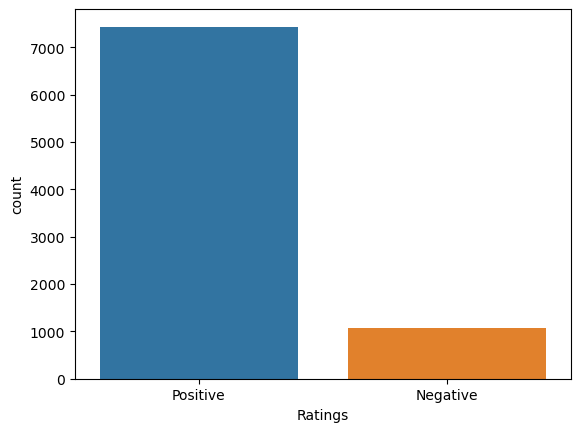

In [12]:
sns.countplot(x='Ratings', data=df)

In [13]:
df = df[['Review text', 'Ratings']]
df.shape

(8510, 2)

## Identify Input and Output

In [14]:
X = df['Review text']
y = df['Ratings']
print(X.shape, y.shape)

(8510,) (8510,)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6382,) (6382,)
(2128,) (2128,)


## Data Preprocessing on train data (X_train)

In [19]:
lemmatizer = WordNetLemmatizer()

In [76]:
# Download the punctuations
nltk.download('punkt')

# Download the stop words corpus
nltk.download('stopwords')

# Downloading wordnet before applying Lemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...


True

In [20]:
def clean(raw_text): 
    text = re.sub("[^a-zA-Z]", " ", raw_text)
    
    text = text.lower()

    tokens = word_tokenize(text)

    # Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Stop word removal
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in lemmatized_tokens if word.lower() not in stop_words]
    
    # Join and return
    return " ".join(filtered_tokens)

In [21]:
# instantiate a vectorizer
vect = CountVectorizer(preprocessor=clean)

# use it to extract features from training data
%time X_train_dtm = vect.fit_transform(X_train)

print(X_train_dtm.shape)

CPU times: total: 5.19 s
Wall time: 5.7 s
(6382, 2599)


## Data Preprocessing on test data (X_test)

In [22]:
X_test_dtm = vect.transform(X_test)

print(X_test_dtm.shape)

(2128, 2599)


## Building a Model (i.e. Train the classifier)

### Naive Bayes

In [23]:
nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")

CPU times: total: 15.6 ms
Wall time: 38.3 ms


MultinomialNB()

### Decision Tree

In [32]:
dt = DecisionTreeClassifier()
%time dt.fit(X_train_dtm, y_train)

CPU times: total: 516 ms
Wall time: 973 ms


DecisionTreeClassifier()

### Logistic Regression

In [33]:
lr = LogisticRegression()
%time lr.fit(X_train_dtm,y_train)

CPU times: total: 46.9 ms
Wall time: 340 ms


LogisticRegression()

## Evaluating on Train Data

### Naive Bayes

In [35]:
y_train_pred = nb.predict(X_train_dtm)

print("Accuracy : ", accuracy_score(y_train, y_train_pred))
print("F1 Score : ",f1_score(y_train, y_train_pred, pos_label='Positive'))

Accuracy :  0.9356001253525541
F1 Score :  0.9637598095406049


In [25]:
confusion_matrix(y_train, y_train_pred)

array([[ 506,  311],
       [ 100, 5465]], dtype=int64)

Text(0.5, 23.52222222222222, 'Predicted')

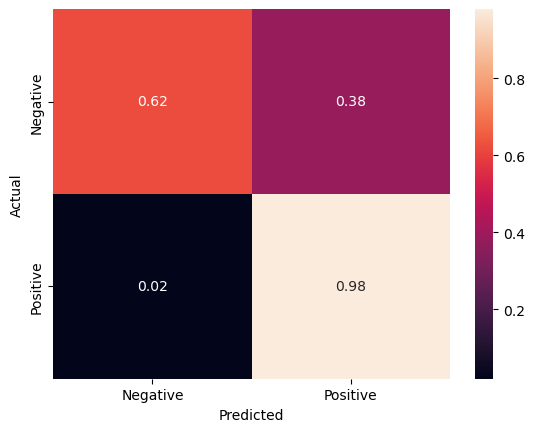

In [27]:
cm = confusion_matrix(y_train, y_train_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Decision Tree

In [36]:
y_train_pred = dt.predict(X_train_dtm)

print("Accuracy : ", accuracy_score(y_train, y_train_pred))
print("F1 Score : ",f1_score(y_train, y_train_pred, pos_label='Positive'))

Accuracy :  0.9804136634283923
F1 Score :  0.9887761515668492


In [37]:
confusion_matrix(y_train, y_train_pred)

array([[ 751,   66],
       [  59, 5506]], dtype=int64)

Text(0.5, 23.52222222222222, 'Predicted')

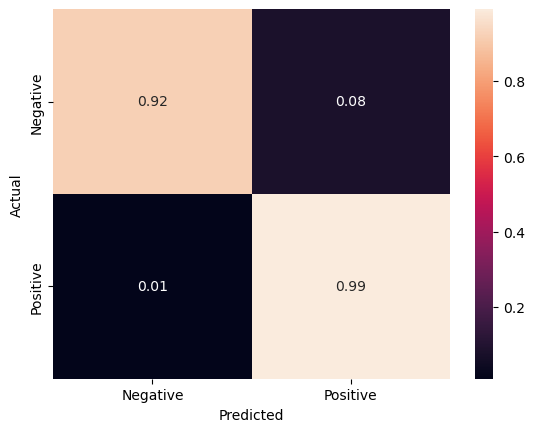

In [38]:
cm = confusion_matrix(y_train, y_train_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Logistic Regression

In [39]:
y_train_pred = lr.predict(X_train_dtm)

print("Accuracy : ", accuracy_score(y_train, y_train_pred))
print("F1 Score : ",f1_score(y_train, y_train_pred, pos_label='Positive'))

Accuracy :  0.9462550924475086
F1 Score :  0.969872639437857


In [40]:
confusion_matrix(y_train, y_train_pred)

array([[ 518,  299],
       [  44, 5521]], dtype=int64)

Text(0.5, 23.52222222222222, 'Predicted')

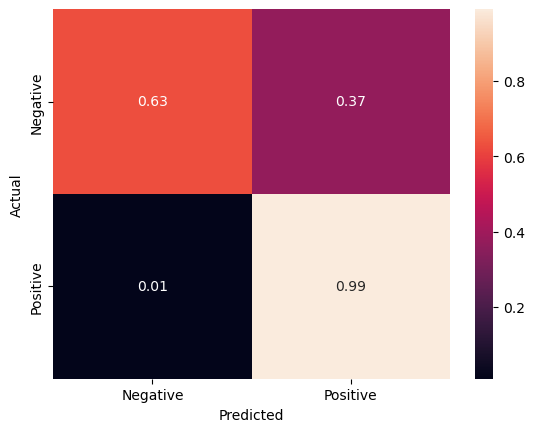

In [41]:
cm = confusion_matrix(y_train, y_train_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

- Naive Bayes F1 Score :  0.9637598095406049
- Decision Tree F1 Score :  0.9887761515668492
- Logistic Regression F1 Score :  0.969872639437857

On the Training Data Decision Tree as higher F1 Score

## Evaluate on Test Data

### Naive Bayes

In [42]:
y_test_pred = nb.predict(X_test_dtm)

print("Accuracy : ",accuracy_score(y_test, y_test_pred))
print("F1 Score : ",f1_score(y_test, y_test_pred, pos_label='Positive'))

Accuracy :  0.9163533834586466
F1 Score :  0.9535732916014606


Text(0.5, 23.52222222222222, 'Predicted')

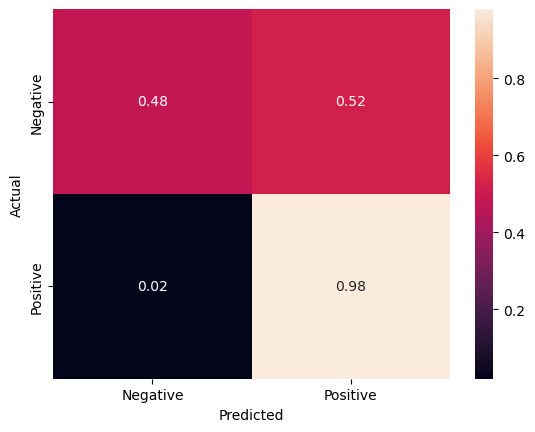

In [43]:
cm = confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Decision Tree

In [44]:
y_test_pred = dt.predict(X_test_dtm)

print("Accuracy : ",accuracy_score(y_test, y_test_pred))
print("F1 Score : ",f1_score(y_test, y_test_pred, pos_label='Positive'))

Accuracy :  0.8928571428571429
F1 Score :  0.939297124600639


Text(0.5, 23.52222222222222, 'Predicted')

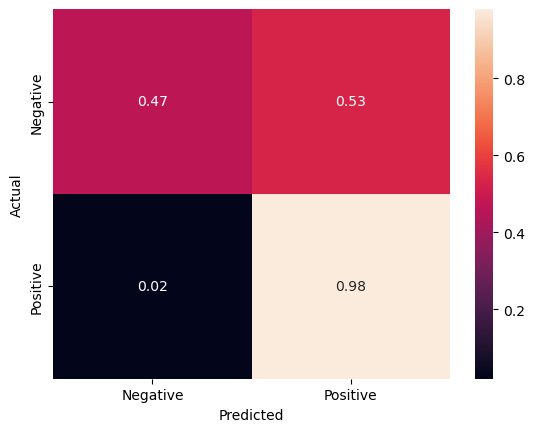

In [46]:
cm = confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Logistic Regression

In [45]:
y_test_pred = lr.predict(X_test_dtm)

print("Accuracy : ",accuracy_score(y_test, y_test_pred))
print("F1 Score : ",f1_score(y_test, y_test_pred, pos_label='Positive'))

Accuracy :  0.9191729323308271
F1 Score :  0.9552782111284451


Text(0.5, 23.52222222222222, 'Predicted')

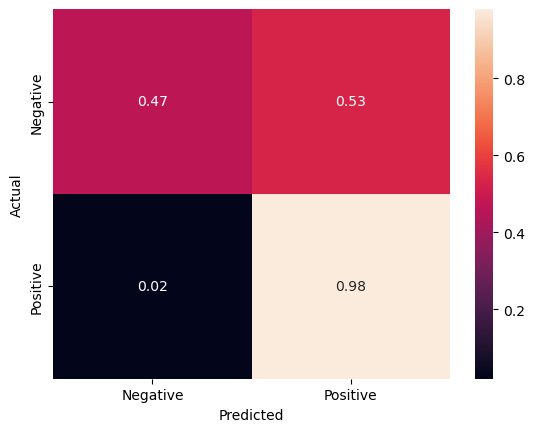

In [47]:
cm = confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

## Hyper parameter tuning

In [49]:
scorer = make_scorer(f1_score, average='macro')

In [50]:
pipe = Pipeline(
    [
        ('vectorization', CountVectorizer(preprocessor=clean)),
        ('tfidf', TfidfTransformer()),
        ('nb', MultinomialNB())
    ]
)

MAX_FEATURES = [1000, 1500, 2000]
ALPHA = [1, 10]

# Observe the Key Value Pair format
parameter_grid = [{'vectorization__max_features' : MAX_FEATURES, 
                   'nb__alpha' : ALPHA}]

clf = GridSearchCV(
    estimator=pipe, 
    param_grid=parameter_grid, 
    scoring=scorer,
    cv=5,
    return_train_score=True,
    verbose=1
)

%time clf.fit(X_train, y_train)

print("Best estimator found on train set")
print(clf.best_estimator_)

print()

print('Score on Test Data: ', clf.score(X_test, y_test))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: total: 4min 6s
Wall time: 4min 25s
Best estimator found on train set
Pipeline(steps=[('vectorization',
                 CountVectorizer(max_features=1000,
                                 preprocessor=<function clean at 0x00000211A1832B60>)),
                ('tfidf', TfidfTransformer()), ('nb', MultinomialNB(alpha=1))])

Score on Test Data:  0.720164335625616


In [51]:
import joblib
from joblib import Memory

import os
import warnings

warnings.filterwarnings('ignore')

In [52]:
X_train_clean = X_train.apply(lambda doc: clean(doc))

In [53]:
X_test_clean = X_test.apply(lambda doc: clean(doc))

In [54]:
# Define a memory object to cache intermediate results
cachedir = '.cache'
memory = Memory(location=cachedir, verbose=0)

pipelines = {
    'naive_bayes': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', MultinomialNB())
    ], memory=memory),
    'decision_tree': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', DecisionTreeClassifier())
    ], memory=memory),
    'logistic_regression': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', LogisticRegression())
    ], memory=memory)
}

# Define parameter grid for each algorithm
param_grids = {
    'naive_bayes': [
        {
            'vectorization': [CountVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000], 
            'classifier__alpha' : [1, 10]
        }
    ],
    'decision_tree': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000],
            'classifier__max_depth': [None, 5, 10]
        }
    ],
    'logistic_regression': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000], 
            'classifier__C': [0.1, 1, 10], 
            'classifier__penalty': ['elasticnet'], 
            'classifier__l1_ratio': [0.4, 0.5, 0.6],
            'classifier__solver': ['saga'],
            'classifier__class_weight': ['balanced']
        }
    ]
}

# Perform GridSearchCV for each algorithm
best_models = {}

for algo in pipelines.keys():
    print("*"*10, algo, "*"*10)
    grid_search = GridSearchCV(estimator=pipelines[algo], 
                               param_grid=param_grids[algo], 
                               cv=5, 
                               scoring=scorer, 
                               return_train_score=True,
                               verbose=1
                              )
    
    %time grid_search.fit(X_train_clean, y_train)
    
    best_models[algo] = grid_search.best_estimator_
    
    print('Score on Test Data: ', grid_search.score(X_test_clean, y_test))

********** naive_bayes **********
Fitting 5 folds for each of 8 candidates, totalling 40 fits
CPU times: total: 12.6 s
Wall time: 14.6 s
Score on Test Data:  0.7846283630611294
********** decision_tree **********
Fitting 5 folds for each of 24 candidates, totalling 120 fits
CPU times: total: 50.3 s
Wall time: 51.8 s
Score on Test Data:  0.7364516286515221
********** logistic_regression **********
Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: total: 7min 51s
Wall time: 8min 10s
Score on Test Data:  0.7814240578705827


In [56]:
for name, model in best_models.items():
    print("-"*10, name, "-"*10)
    
    joblib.dump(model, f'best_models/{name}.pkl')
    model = joblib.load(f'best_models/{name}.pkl')
    
    print("Test Score (F1)", f1_score(y_test, y_test_pred,pos_label='Positive'))


---------- naive_bayes ----------
Test Score (F1) 0.9552782111284451
---------- decision_tree ----------
Test Score (F1) 0.9552782111284451
---------- logistic_regression ----------
Test Score (F1) 0.9552782111284451


In [69]:
model = joblib.load('best_models/naive_bayes.pkl')

In [70]:
new_data = ["""I recently purchased the Yonex Mavis 350 Nylon Shuttlecocks in yellow for my badminton games, and I must say I'm thoroughly impressed. These shuttlecocks offer excellent durability and flight consistency, making them ideal for recreational play.

The nylon skirt of the shuttlecock holds up well even after prolonged use, showing minimal signs of wear and tear. This durability ensures that the shuttlecock maintains its flight characteristics over time, providing consistent performance during every game.

Additionally, the bright yellow color of the shuttlecocks makes them easy to spot during gameplay, enhancing visibility and reducing the chances of losing them on the court. The color also adds a vibrant touch to the game, making it more enjoyable.

The shuttlecocks fly true and have a good balance of speed and stability, allowing for precise shots and rallies. Whether you're playing singles or doubles, these shuttlecocks deliver reliable performance and help elevate your game to the next level.

Overall, I highly recommend the Yonex Mavis 350 Nylon Shuttlecocks to badminton enthusiasts of all skill levels. They offer exceptional quality, durability, and performance, making them a worthwhile investment for any player looking to enjoy the game to the fullest."""]


In [71]:
new_data_clean = [clean(doc) for doc in new_data]

prediction = model.predict(new_data)

print("Prediction:", prediction)

Prediction: ['Positive']


In [72]:
new_data = ["""I recently purchased the Yonex Mavis 350 Nylon Shuttlecocks in yellow with high hopes, but unfortunately, my experience with them has been quite disappointing. The shuttlecocks started showing signs of wear and tear after just a few uses, with the nylon skirt quickly fraying and becoming misshapen.

Despite claims of durability, these shuttlecocks failed to live up to expectations, as they became unusable much sooner than anticipated. The flight consistency was also lacking, with the shuttlecocks often veering off course mid-flight, leading to frustrating and inconsistent gameplay.

Furthermore, the bright yellow color, while initially appealing, quickly faded after minimal exposure to sunlight, making the shuttlecocks difficult to spot on the court. This resulted in frequent interruptions during gameplay, as players struggled to locate the shuttlecocks amidst the confusion.

Overall, I cannot recommend the Yonex Mavis 350 Nylon Shuttlecocks based on my experience. The lack of durability, inconsistent flight, and poor color retention make them a subpar choice for anyone seeking reliable and long-lasting shuttlecocks for their badminton games."""]

In [73]:
new_data_clean = [clean(doc) for doc in new_data]

prediction = model.predict(new_data)

print("Prediction:", prediction)

Prediction: ['Negative']
